In [1]:
import pandas as pd
from pandas.tseries.offsets import DateOffset
import requests
from bs4 import BeautifulSoup
import json
from collections import Counter
from matplotlib import pyplot as plt
from datetime import datetime
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_absolute_percentage_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import re
import nltk

from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.action_chains import ActionChains
from selenium.common.exceptions import NoSuchElementException, TimeoutException
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium import webdriver

In [3]:
import pandas as pd
import requests
import re
from datetime import datetime

def get_latest_cleaned_csv_url(user, repo, path="data/cleaned"):
    api_url = f"https://api.github.com/repos/{user}/{repo}/contents/{path}"
    response = requests.get(api_url)
    files = response.json()

    csv_files = []
    for file in files:
        name = file['name']
        if name.startswith("retail_sugar_prices_") and name.endswith(".csv"):
            match = re.search(r"(\d{4}-\d{2}-\d{2})", name)
            if match:
                csv_files.append((match.group(1), name))

    if not csv_files:
        raise ValueError("❌ No cleaned CSV files found.")

    # Get latest date
    latest_date, latest_file = sorted(csv_files)[-1]
    print(f"📁 Latest file found: {latest_file}")

    raw_url = f"https://raw.githubusercontent.com/{user}/{repo}/main/{path}/{latest_file}"
    return raw_url

# === USE IT ===
user = "Neeti3107"
repo = "Foundation-Project_Group-14"
latest_csv_url = get_latest_cleaned_csv_url(user, repo)

# Load the file
df_filtered = pd.read_csv(latest_csv_url, parse_dates=['date'])
df_filtered.head()

📁 Latest file found: retail_sugar_prices_2025-04-16.csv


,date,admin1,admin2,market,market_id,latitude,longitude,category,commodity,commodity_id,unit,priceflag,pricetype,currency,price,usdprice
0,1994-01-15,Gujarat,Ahmadabad,Ahmedabad,923,23.03,72.62,miscellaneous food,sugar,97,KG,actual,retail,INR,13.5,0.43
1,1994-01-15,Karnataka,Bangalore Urban,Bengaluru,926,12.96,77.58,miscellaneous food,sugar,97,KG,actual,retail,INR,13.2,0.42
2,1994-01-15,Maharashtra,Mumbai city,Mumbai,955,18.98,72.83,miscellaneous food,sugar,97,KG,actual,retail,INR,13.8,0.44
3,1994-01-15,Orissa,Khordha,Bhubaneshwar,929,20.23,85.83,miscellaneous food,sugar,97,KG,actual,retail,INR,13.5,0.43
4,1994-01-15,Tripura,West Tripura,Agartala,921,23.84,91.28,miscellaneous food,sugar,97,KG,actual,retail,INR,16.0,0.51


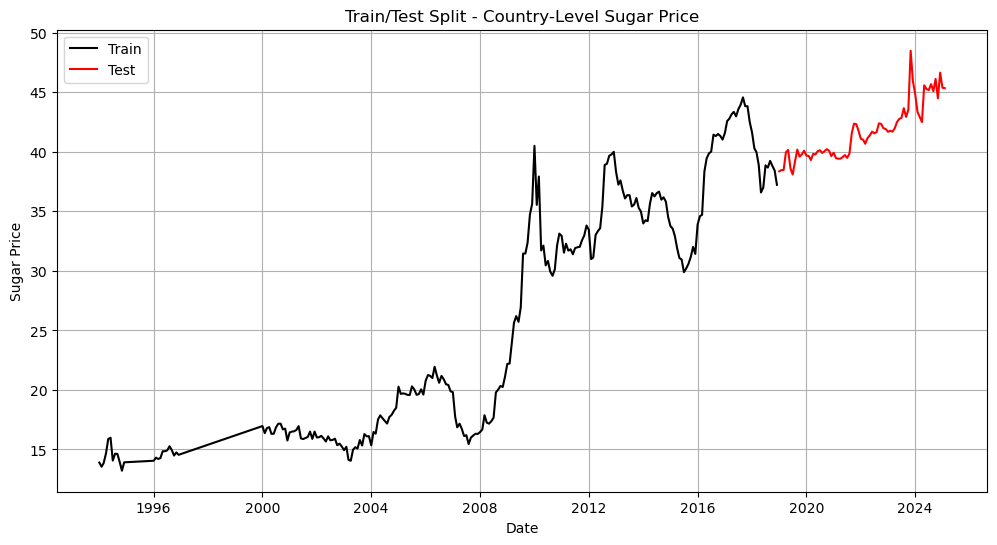

=== ADF Test on Original Series ===
ADF Statistic : -0.9168
p-value : 0.7824
Lags Used : 2
Critical Values :
    1%: -3.4508
    5%: -2.8706
    10%: -2.5716

=== ADF Test on Rolling Mean Differenced Series ===
ADF Statistic : -4.6970
p-value : 0.0001
Lags Used : 16
Critical Values :
    1%: -3.4526
    5%: -2.8714
    10%: -2.5720


In [4]:
# 📦 Required Libraries
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX

# 🧹 Step 1: Aggregate Monthly Country-level Data
df_filtered['month'] = df_filtered['date'].dt.to_period('M')
df_country = df_filtered.groupby('month')['price'].mean().reset_index()
df_country['month'] = df_country['month'].dt.to_timestamp()
df_country.set_index('month', inplace=True)


# 📆 Step 2: Train/Test Split
df_train = df_country[df_country.index < pd.to_datetime("2019-01-01")]
df_test = df_country[df_country.index >= pd.to_datetime("2019-01-01")]

# 📊 Step 3: Plot
plt.figure(figsize=(12, 6))
plt.plot(df_train.index, df_train['price'], label='Train', color='black')
plt.plot(df_test.index, df_test['price'], label='Test', color='red')
plt.xlabel("Date")
plt.ylabel("Sugar Price")
plt.title("Train/Test Split - Country-Level Sugar Price")
plt.legend()
plt.grid(True)
plt.show()

# 🧪 Step 4: ADFuller Test for Stationarity (on full data)
print("=== ADF Test on Original Series ===")
adf_result = adfuller(df_country['price'])
print(f"ADF Statistic : {adf_result[0]:.4f}")
print(f"p-value : {adf_result[1]:.4f}")
print(f"Lags Used : {adf_result[2]}")
print("Critical Values :")
for key, value in adf_result[4].items():
    print(f"    {key}: {value:.4f}")

# 🌀 Step 5: Differencing with Rolling Mean (if non-stationary)
rolling_mean = df_country['price'].rolling(window=12).mean()
df_country['rolling_mean_diff'] = rolling_mean - rolling_mean.shift()

# 📉 Step 6: ADF Test on Differenced Series
print("\n=== ADF Test on Rolling Mean Differenced Series ===")
adf_result_diff = adfuller(df_country['rolling_mean_diff'].dropna())
print(f"ADF Statistic : {adf_result_diff[0]:.4f}")
print(f"p-value : {adf_result_diff[1]:.4f}")
print(f"Lags Used : {adf_result_diff[2]}")
print("Critical Values :")
for key, value in adf_result_diff[4].items():
    print(f"    {key}: {value:.4f}")


### 🧪 ADF Test Insights: Stationarity Check of Sugar Prices

#### 📉 Original Series (Non-Stationary)

- **ADF Statistic**: -0.9168  
- **p-value**: 0.7824  
- **Conclusion**:  
  - The p-value is **greater than 0.05**, so we **fail to reject** the null hypothesis.
  - This implies that the sugar price time series is **non-stationary** in its original form.
  - This is expected, as sugar prices show a long-term upward **trend** and **seasonal behavior**.

---

#### 🔁 Transformed Series (Rolling Mean Differenced)

- **ADF Statistic**: -4.6970  
- **p-value**: 0.0001  
- **Conclusion**:  
  - The p-value is **less than 0.05**, so we **reject** the null hypothesis.
  - The rolling mean differenced series is **stationary**.
  - The transformation effectively removed **trend and seasonality**, making it suitable for time series modeling.

---

#### ✅ Summary Table

| Series                        | ADF Statistic | p-value | Stationary?      |
|------------------------------|---------------|---------|------------------|
| Original                     | -0.9168       | 0.7824  | ❌ No             |
| Rolling Mean Differenced     | -4.6970       | 0.0001  | ✅ Yes            |

---




Fitting ARMA(2,0,2) model on original price series...


C:\Users\neeti\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\neeti\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\neeti\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\neeti\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Use

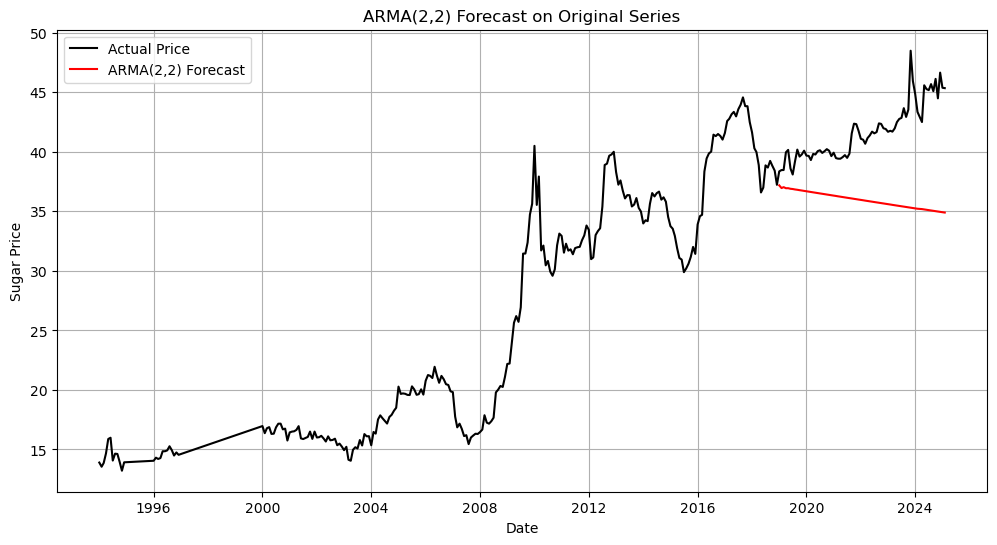

Fitting ARMA(2,0,2) model on stationary rolling mean differenced series...


C:\Users\neeti\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\neeti\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


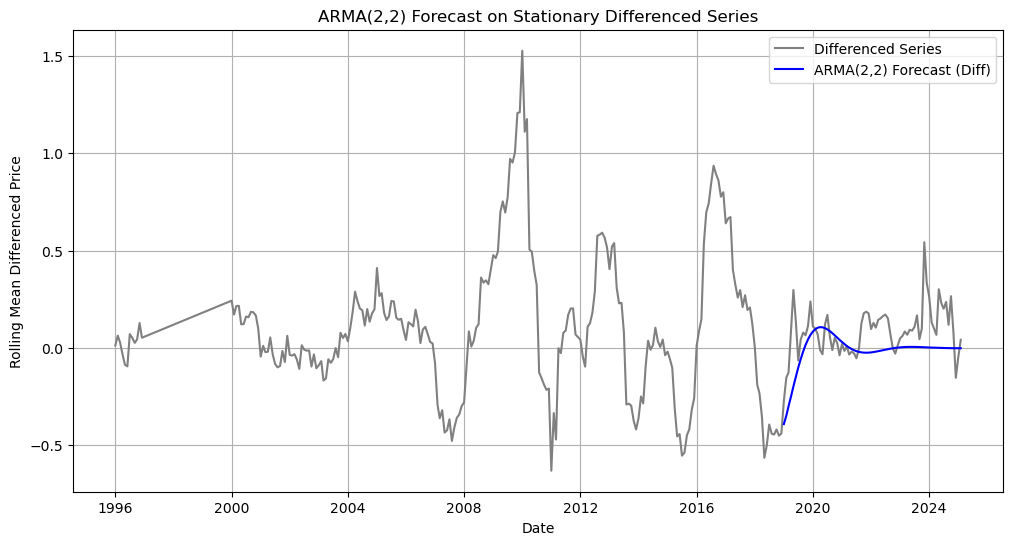

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Copy full monthly country-level data
df_data = df_country.copy()

# Train-test split
split_date = pd.to_datetime("2019-01-01")
df_train = df_data[df_data.index < split_date]
df_test = df_data[df_data.index >= split_date]
df_test_copy = df_test.copy()

# ============================================
# ⚙️ ARMA(2,0,2) Model on Original Series (Price)
# ============================================
print("Fitting ARMA(2,0,2) model on original price series...")

# Fit ARMA on original price series
arma_model_price = SARIMAX(df_train['price'], order=(2, 0, 2))
arma_model_price = arma_model_price.fit(disp=False)

# Forecast
start_idx = len(df_train)
end_idx = start_idx + len(df_test) - 1
arma_forecast_price = arma_model_price.predict(start=start_idx, end=end_idx, dynamic=True)

# Store forecast
df_test_copy['arma_forecast_original'] = arma_forecast_price.values

# Plot forecast vs actual
plt.figure(figsize=(12, 6))
plt.plot(df_data.index, df_data['price'], label='Actual Price', color='black')
plt.plot(df_test_copy.index, df_test_copy['arma_forecast_original'], label='ARMA(2,2) Forecast', color='red')
plt.title("ARMA(2,2) Forecast on Original Series")
plt.xlabel("Date")
plt.ylabel("Sugar Price")
plt.legend()
plt.grid(True)
plt.show()

# ============================================================
# ⚙️ ARMA(2,0,2) Model on Rolling Mean Differenced Series
# ============================================================
print("Fitting ARMA(2,0,2) model on stationary rolling mean differenced series...")

# Create 12-month rolling mean differenced series
df_data['rolling_mean'] = df_data['price'].rolling(window=12).mean()
df_data['rolling_mean_diff'] = df_data['rolling_mean'] - df_data['rolling_mean'].shift()
rolling_diff = df_data['rolling_mean_diff'].dropna()

# Fit ARMA on differenced series
arma_model_rolling = SARIMAX(rolling_diff, order=(2, 0, 2))
arma_model_rolling = arma_model_rolling.fit(disp=False)

# Forecast
start_idx_diff = len(rolling_diff) - len(df_test)
end_idx_diff = start_idx_diff + len(df_test) - 1
arma_forecast_diff = arma_model_rolling.predict(start=start_idx_diff, end=end_idx_diff, dynamic=True)

# Align forecast
forecast_index = rolling_diff.index[start_idx_diff:end_idx_diff + 1]
df_data.loc[forecast_index, 'arma_forecast_diff'] = arma_forecast_diff.values

# Plot forecast on stationary differenced series
plt.figure(figsize=(12, 6))
plt.plot(df_data['rolling_mean_diff'], label='Differenced Series', color='gray')
plt.plot(forecast_index, arma_forecast_diff, label='ARMA(2,2) Forecast (Diff)', color='blue')
plt.title("ARMA(2,2) Forecast on Stationary Differenced Series")
plt.xlabel("Date")
plt.ylabel("Rolling Mean Differenced Price")
plt.legend()
plt.grid(True)
plt.show()


In [6]:
# ================
# Evaluation: Original Series Forecast
# ================
rmse_original = np.sqrt(mean_squared_error(df_test['price'], df_test_copy['arma_forecast_original']))
mae_original = mean_absolute_error(df_test['price'], df_test_copy['arma_forecast_original'])

print("\n🔍 ARMA(2,2) on Original Price Series:")
print(f"RMSE: {rmse_original:.4f}")
print(f"MAE : {mae_original:.4f}")

# ============================
# Evaluation: Differenced Series Forecast
# ============================

# Drop NA to align ground truth and forecast
true_diff = df_data.loc[forecast_index, 'rolling_mean_diff'].dropna()
pred_diff = df_data.loc[forecast_index, 'arma_forecast_diff'].dropna()

# Ensure alignment
true_diff, pred_diff = true_diff.align(pred_diff, join='inner')

rmse_diff = np.sqrt(mean_squared_error(true_diff, pred_diff))
mae_diff = mean_absolute_error(true_diff, pred_diff)

print("\n🔍 ARMA(2,2) on Rolling Mean Differenced Series:")
print(f"RMSE: {rmse_diff:.4f}")
print(f"MAE : {mae_diff:.4f}")


🔍 ARMA(2,2) on Original Price Series:
RMSE: 6.3573
MAE : 5.6535

🔍 ARMA(2,2) on Rolling Mean Differenced Series:
RMSE: 0.1621
MAE : 0.1216


In [7]:
print(arma_model_price.summary())


                               SARIMAX Results                                
Dep. Variable:                  price   No. Observations:                  252
Model:               SARIMAX(2, 0, 2)   Log Likelihood                -367.543
Date:                Thu, 17 Apr 2025   AIC                            745.087
Time:                        12:45:23   BIC                            762.734
Sample:                             0   HQIC                           752.188
                                - 252                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4461      0.161      2.778      0.005       0.131       0.761
ar.L2          0.5526      0.161      3.430      0.001       0.237       0.868
ma.L1          0.5252      0.163      3.224      0.0

## 🔍 Interpretation of ARMA(2,2) Model on Sugar Prices

The ARMA(2,2) model captures the relationship between current sugar prices, their past values, and recent forecast errors. The model estimates are as follows:

### ✅ Model Coefficients:
- **AR(1) = 0.4461**: The current price is positively influenced by 44.6% of the previous month's price.
- **AR(2) = 0.5526**: There is a 55.3% influence from the price two months ago.
- **MA(1) = 0.5252**: The model adjusts for 52.5% of the previous forecast error.
- **MA(2) = 0.1988**: It also adjusts for 19.9% of the forecast error from two months ago.

All coefficients are **statistically significant (p < 0.01)**, indicating that they contribute meaningfully to the model.

### 📊 Model Diagnostics:
- **AIC = 745.1**: Lower than more complex models like ARMA(11,11), suggesting a more efficient fit.
- **Ljung-Box Test (p = 0.94)**: No autocorrelation in residuals — the model captures temporal dependencies well.
- **Jarque-Bera Test (p ≈ 0.00)**: Residuals deviate from normality, indicating some non-Gaussian behavior.

### 📉 Forecast Accuracy:

| Model Type                         | RMSE   | MAE    |
|-----------------------------------|--------|--------|
| **Original Price Series**         | 6.3573 | 5.6535 |
| **Rolling Mean Differenced Series** | 0.1621 | 0.1216 |

The forecast errors are notably lower for the rolling mean differenced series, reflecting that differencing made the series more stationary and predictable. However, the forecasted values in this case are not in the original price scale, and interpreting them requires reversing the differencing step.

### 📌 Summary:
The ARMA(2,2) model provides a statistically robust and interpretable structure for modeling monthly sugar prices. It strikes a balance between model complexity and forecasting performance. While it slightly underperforms on the original series compared to more complex alternatives, it is a strong candidate due to its simplicity and significance of parameters.


Fitting ARIMA(2,1,2) on original price series...


C:\Users\neeti\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\neeti\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\neeti\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\neeti\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_predict

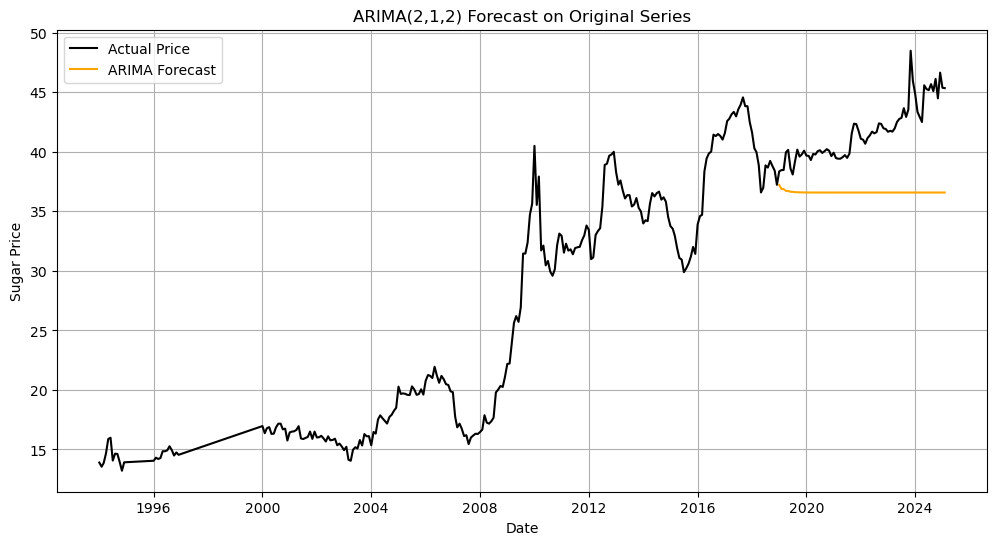

🔍 ARIMA(2,1,2) on Original Price Series:
RMSE: 5.5426
MAE : 5.0165
Fitting ARIMA(2,1,2) on rolling mean differenced series...


C:\Users\neeti\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\neeti\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


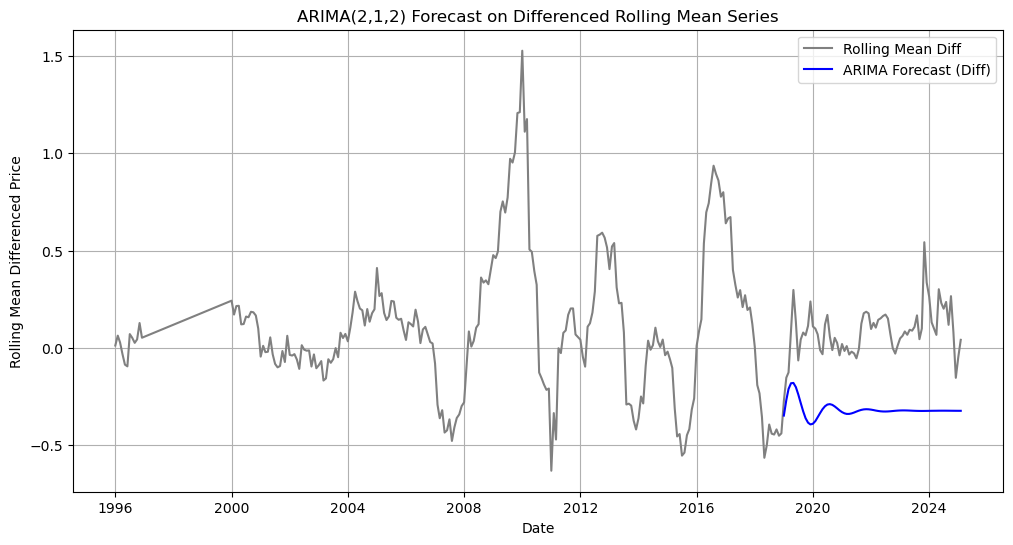

🔍 ARIMA(2,1,2) on Rolling Mean Differenced Series:
RMSE: 0.4223
MAE : 0.4021


In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Copy your monthly country-level data
df_data = df_country.copy()

# Train-test split
split_date = pd.to_datetime("2019-01-01")
df_train = df_data[df_data.index < split_date]
df_test = df_data[df_data.index >= split_date]
df_test_copy = df_test.copy()

# ======================================================
# 🔁 ARIMA(2,1,2) on Original Price Series
# ======================================================
print("Fitting ARIMA(2,1,2) on original price series...")

# Fit ARIMA model on original price series
arima_model = SARIMAX(df_train['price'], order=(2, 1, 2))
arima_result = arima_model.fit(disp=False)

# Forecast using relative positions
start_idx = len(df_train)
end_idx = start_idx + len(df_test) - 1
forecast_arima = arima_result.predict(start=start_idx, end=end_idx, dynamic=True)

# Save forecast
df_test_copy['arima_forecast_original'] = forecast_arima.values

# Plot
plt.figure(figsize=(12, 6))
plt.plot(df_data.index, df_data['price'], label='Actual Price', color='black')
plt.plot(df_test_copy.index, df_test_copy['arima_forecast_original'], label='ARIMA Forecast', color='orange')
plt.title("ARIMA(2,1,2) Forecast on Original Series")
plt.xlabel("Date")
plt.ylabel("Sugar Price")
plt.legend()
plt.grid(True)
plt.show()

# Compute error metrics
rmse_orig = np.sqrt(mean_squared_error(df_test['price'], df_test_copy['arima_forecast_original']))
mae_orig = mean_absolute_error(df_test['price'], df_test_copy['arima_forecast_original'])

print(f"🔍 ARIMA(2,1,2) on Original Price Series:\nRMSE: {rmse_orig:.4f}\nMAE : {mae_orig:.4f}")


# ================================================================
# 🔁 ARIMA(2,1,2) on 12-Month Rolling Mean Differenced Series
# ================================================================
print("Fitting ARIMA(2,1,2) on rolling mean differenced series...")

# Create rolling mean differenced series
df_data['rolling_mean'] = df_data['price'].rolling(window=12).mean()
df_data['rolling_mean_diff'] = df_data['rolling_mean'] - df_data['rolling_mean'].shift()
rolling_diff = df_data['rolling_mean_diff'].dropna()

# Fit ARIMA model on stationary series
arima_model_roll = SARIMAX(rolling_diff, order=(2, 1, 2))
arima_result_roll = arima_model_roll.fit(disp=False)

# Forecast using relative positions
start_idx_diff = len(rolling_diff) - len(df_test)
end_idx_diff = start_idx_diff + len(df_test) - 1
forecast_arima_diff = arima_result_roll.predict(start=start_idx_diff, end=end_idx_diff, dynamic=True)

# Align index
forecast_index = rolling_diff.index[start_idx_diff:end_idx_diff + 1]
df_data.loc[forecast_index, 'arima_forecast_diff'] = forecast_arima_diff.values

# Plot
plt.figure(figsize=(12, 6))
plt.plot(df_data['rolling_mean_diff'], label='Rolling Mean Diff', color='gray')
plt.plot(forecast_index, forecast_arima_diff, label='ARIMA Forecast (Diff)', color='blue')
plt.title("ARIMA(2,1,2) Forecast on Differenced Rolling Mean Series")
plt.xlabel("Date")
plt.ylabel("Rolling Mean Differenced Price")
plt.legend()
plt.grid(True)
plt.show()

# Evaluate performance (dropna to align with test range)
true_diff = df_data.loc[forecast_index, 'rolling_mean_diff'].dropna()
forecast_diff = df_data.loc[forecast_index, 'arima_forecast_diff'].dropna()

rmse_diff = np.sqrt(mean_squared_error(true_diff, forecast_diff))
mae_diff = mean_absolute_error(true_diff, forecast_diff)

print(f"🔍 ARIMA(2,1,2) on Rolling Mean Differenced Series:\nRMSE: {rmse_diff:.4f}\nMAE : {mae_diff:.4f}")


## 📌 ARIMA(2,1,2) Model Insights

We applied the ARIMA(2,1,2) model on both the original sugar price series and the rolling mean differenced (stationary) version of the series. Below are the evaluation metrics and key observations.

### 🔍 ARIMA(2,1,2) on Original Price Series:
- **Root Mean Squared Error (RMSE):** 5.5426  
- **Mean Absolute Error (MAE):** 5.0165  

**📝 Interpretation:**  
The ARIMA model incorporates one level of differencing to account for potential non-stationarity in the original price series. While it captures long-term trend components, the forecast deviates more from the actual prices compared to the ARMA(2,2) model. This could be due to:
- Differencing removing valuable structure or seasonality in the data.
- Remaining seasonal or cyclical patterns not addressed by the non-seasonal ARIMA model.

---

### 🔍 ARIMA(2,1,2) on Rolling Mean Differenced Series:
- **Root Mean Squared Error (RMSE):** 0.4223  
- **Mean Absolute Error (MAE):** 0.4021  

**📝 Interpretation:**  
Applied to a transformed, rolling mean differenced series, the model fits the data better numerically. However, since the series is scaled and smoothed, this improvement doesn’t directly reflect performance on the original price level. While useful for trend detection, this model may not be as effective for actionable forecasting in absolute price terms.

---

### 💡 Key Takeaway:
Despite numerical improvements on the differenced series, the ARIMA(2,1,2) model underperforms the simpler ARMA(2,2) on the **original price series**. This suggests that:
- Differencing may not be necessary for this dataset.
- The series may be already stationary or nearly so.
- A seasonal model (e.g., SARIMA) might better handle recurring patterns in the data.



In [9]:
print("\n=== ARIMA(2,1,2) Summary on Rolling Mean Differenced Series ===")
print(arima_result_roll.summary())



=== ARIMA(2,1,2) Summary on Rolling Mean Differenced Series ===
                               SARIMAX Results                                
Dep. Variable:      rolling_mean_diff   No. Observations:                  313
Model:               SARIMAX(2, 1, 2)   Log Likelihood                 242.174
Date:                Thu, 17 Apr 2025   AIC                           -474.349
Time:                        12:45:25   BIC                           -455.634
Sample:                             0   HQIC                          -466.869
                                - 313                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.6672      0.037     44.798      0.000       1.594       1.740
ar.L2         -0.8271      0.035    -23.897      0.000      -0.895

🔁 Fitting SARIMA(2,1,2)(1,1,1,12) on original price series...


C:\Users\neeti\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\neeti\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\neeti\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\neeti\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_predict

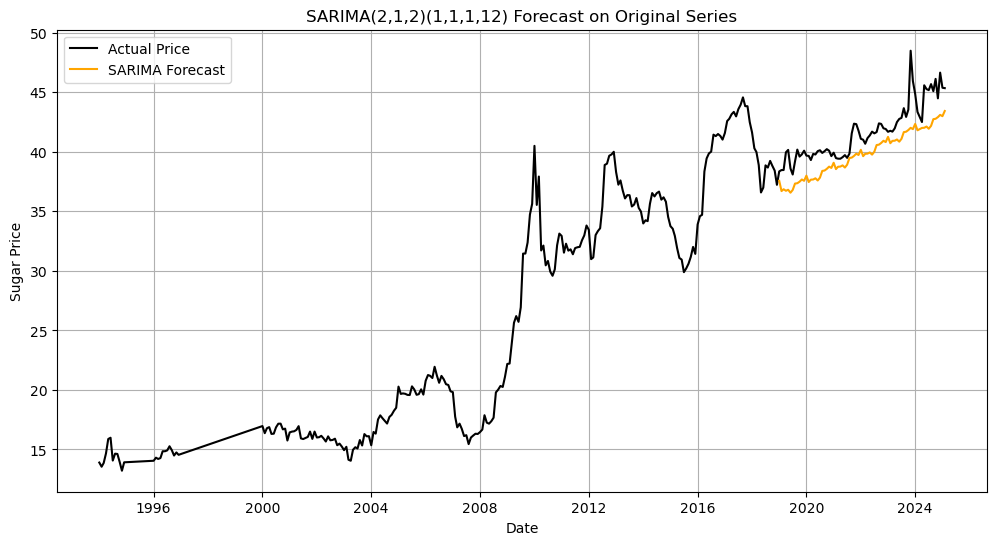

📊 SARIMA on Original Price Series:
RMSE: 2.1080
MAE : 1.8513

🔁 Fitting SARIMA(2,1,2)(1,1,1,12) on rolling mean differenced series...


C:\Users\neeti\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\neeti\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\neeti\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\neeti\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_predict

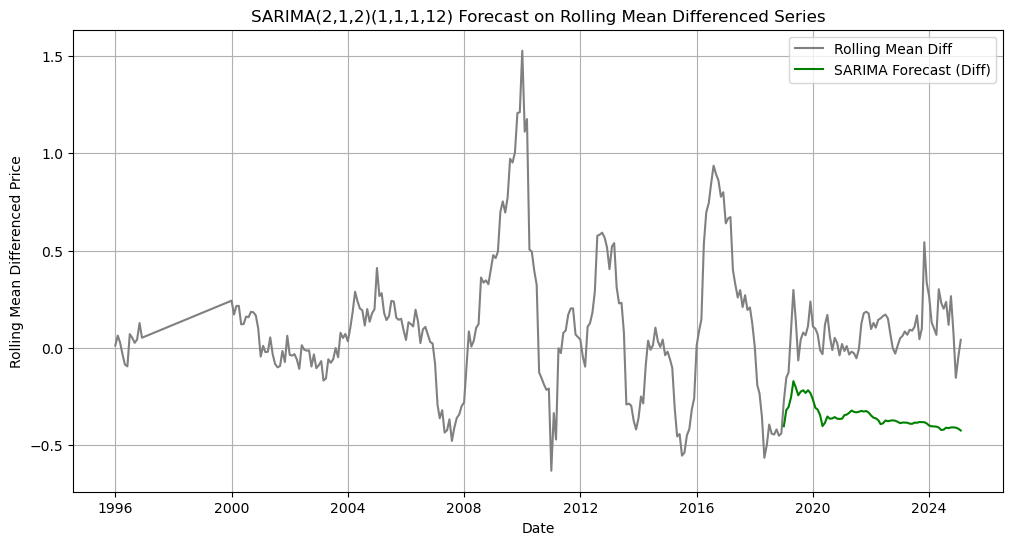

📊 SARIMA on Rolling Mean Differenced Series:
RMSE: 0.4574
MAE : 0.4364


In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Copy your monthly country-level data
df_data = df_country.copy()

# Create rolling mean and differenced series
df_data['rolling_mean'] = df_data['price'].rolling(window=12).mean()
df_data['rolling_mean_diff'] = df_data['rolling_mean'] - df_data['rolling_mean'].shift()
rolling_diff = df_data['rolling_mean_diff'].dropna()

# Train-test split
split_date = pd.to_datetime("2019-01-01")
df_train_orig = df_data[df_data.index < split_date]
df_test_orig = df_data[df_data.index >= split_date]
df_test_copy = df_test_orig.copy()

df_train_roll = rolling_diff[rolling_diff.index < split_date]
df_test_roll = rolling_diff[rolling_diff.index >= split_date]

# =====================================================
# 1️⃣ SARIMA on Original Price Series
# =====================================================
print("🔁 Fitting SARIMA(2,1,2)(1,1,1,12) on original price series...")

sarima_model_orig = SARIMAX(
    df_train_orig['price'],
    order=(2, 1, 2),
    seasonal_order=(1, 1, 1, 12),
    enforce_stationarity=False,
    enforce_invertibility=False
)

sarima_result_orig = sarima_model_orig.fit(disp=False)

# Forecast
start_idx_orig = len(df_train_orig)
end_idx_orig = start_idx_orig + len(df_test_orig) - 1
forecast_sarima_orig = sarima_result_orig.predict(start=start_idx_orig, end=end_idx_orig, dynamic=True)

# Save forecast
df_test_copy['sarima_forecast_original'] = forecast_sarima_orig.values

# Plot original
plt.figure(figsize=(12, 6))
plt.plot(df_data.index, df_data['price'], label='Actual Price', color='black')
plt.plot(df_test_copy.index, df_test_copy['sarima_forecast_original'], label='SARIMA Forecast', color='orange')
plt.title("SARIMA(2,1,2)(1,1,1,12) Forecast on Original Series")
plt.xlabel("Date")
plt.ylabel("Sugar Price")
plt.legend()
plt.grid(True)
plt.show()

# Metrics
rmse_orig = np.sqrt(mean_squared_error(df_test_orig['price'], df_test_copy['sarima_forecast_original']))
mae_orig = mean_absolute_error(df_test_orig['price'], df_test_copy['sarima_forecast_original'])

print(f"📊 SARIMA on Original Price Series:\nRMSE: {rmse_orig:.4f}\nMAE : {mae_orig:.4f}")

# =====================================================
# 2️⃣ SARIMA on Rolling Mean Differenced Series
# =====================================================
print("\n🔁 Fitting SARIMA(2,1,2)(1,1,1,12) on rolling mean differenced series...")

sarima_model_roll = SARIMAX(
    df_train_roll,
    order=(2, 1, 2),
    seasonal_order=(1, 1, 1, 12),
    enforce_stationarity=False,
    enforce_invertibility=False
)

sarima_result_roll = sarima_model_roll.fit(disp=False)

# Forecast
start_idx_roll = len(df_train_roll)
end_idx_roll = start_idx_roll + len(df_test_roll) - 1
forecast_sarima_roll = sarima_result_roll.predict(start=start_idx_roll, end=end_idx_roll, dynamic=True)

# Save forecast in main df
forecast_index = df_test_roll.index
df_data.loc[forecast_index, 'sarima_forecast_diff'] = forecast_sarima_roll.values

# Plot rolling
plt.figure(figsize=(12, 6))
plt.plot(df_data['rolling_mean_diff'], label='Rolling Mean Diff', color='gray')
plt.plot(forecast_index, forecast_sarima_roll, label='SARIMA Forecast (Diff)', color='green')
plt.title("SARIMA(2,1,2)(1,1,1,12) Forecast on Rolling Mean Differenced Series")
plt.xlabel("Date")
plt.ylabel("Rolling Mean Differenced Price")
plt.legend()
plt.grid(True)
plt.show()

# Metrics
true_diff = df_data.loc[forecast_index, 'rolling_mean_diff'].dropna()
forecast_diff = df_data.loc[forecast_index, 'sarima_forecast_diff'].dropna()

rmse_roll = np.sqrt(mean_squared_error(true_diff, forecast_diff))
mae_roll = mean_absolute_error(true_diff, forecast_diff)

print(f"📊 SARIMA on Rolling Mean Differenced Series:\nRMSE: {rmse_roll:.4f}\nMAE : {mae_roll:.4f}")


## 📊 SARIMA Modeling Insights (Sugar Price Series)

### 🧪 1. Model Comparison Results

| Model                                  | RMSE   | MAE    |
|----------------------------------------|--------|--------|
| SARIMA on Original Series              | 2.1080 | 1.8513 |
| SARIMA on Rolling Mean Differenced Series | 0.4574 | 0.4364 |

- ✅ Lower RMSE/MAE for rolling-mean differenced SARIMA suggests better short-term forecasting performance due to improved stationarity.
- ⚠️ The original series, with trend and seasonality, caused higher forecast errors.

---

### 🔍 2. Seasonal Decomposition Analysis

- **Trend**: Long-term upward trend in sugar prices, especially post-2008.
- **Seasonality**: Clear annual cycle (12-month pattern) with consistent amplitude.
- **Residuals**: Mostly stable, but contain occasional spikes (e.g., 2011–2012), indicating market shocks not captured by trend/seasonality.

---

### 💡 3. Next Steps

- Consider using **LSTM** (Long Short-Term Memory neural networks):
  - Captures nonlinear and long-range dependencies.
  - Handles seasonality and trend without explicit decomposition.
  - More robust against irregular spikes and volatile fluctuations.


📁 Latest file found: retail_sugar_prices_2025-04-16.csv


C:\Users\neeti\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step


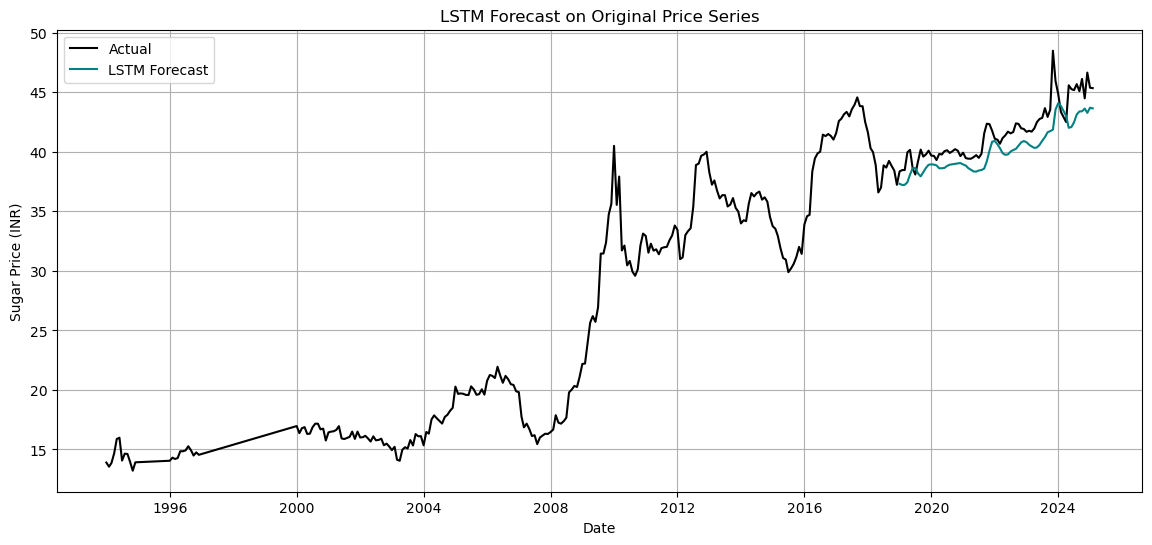

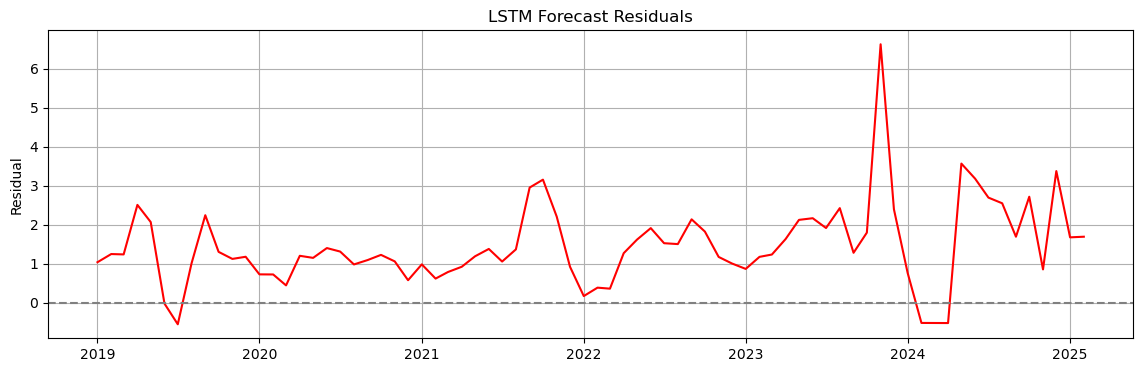

📊 LSTM Forecast on Original Price Series
RMSE: 1.8185
MAE : 1.5296


C:\Users\neeti\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 158ms/step


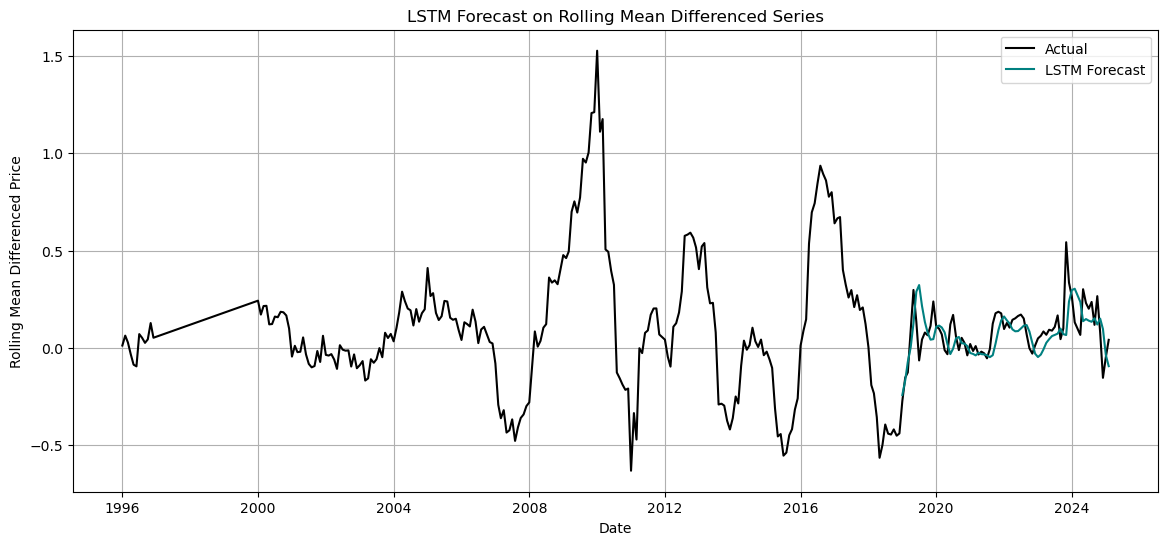

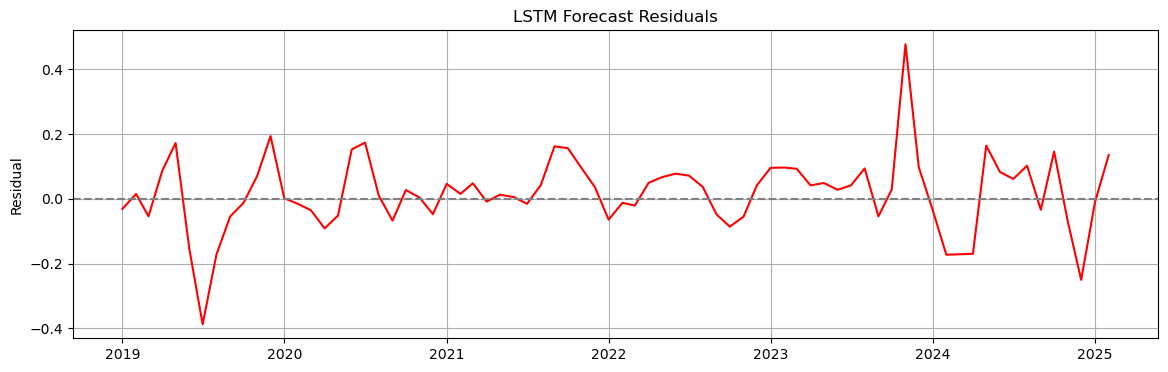

📊 LSTM Forecast on Rolling Mean Differenced Series
RMSE: 0.1152
MAE : 0.0819
✅ Model saved to: C:\Users\neeti\Documents\ISB_Class of Summer_2025\04 Term 4\Foundation\Foundation-Project_Group-14\models\lstm_model_rolling_diff_2025-04-17.h5
✅ Scaler saved to: C:\Users\neeti\Documents\ISB_Class of Summer_2025\04 Term 4\Foundation\Foundation-Project_Group-14\models\lstm_scaler_rolling_diff_2025-04-17.pkl


(<Sequential name=sequential_12, built=True>, MinMaxScaler())

In [20]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.models import Sequential
from keras.layers import LSTM, Dense
import joblib
import os
import re
import requests
from datetime import datetime
import random
import tensorflow as tf

# === Set Seed for Reproducibility ===
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

def get_latest_cleaned_csv_url(user, repo, path="data/cleaned"):
    api_url = f"https://api.github.com/repos/{user}/{repo}/contents/{path}"
    response = requests.get(api_url)
    files = response.json()

    csv_files = []
    for file in files:
        name = file['name']
        if name.startswith("retail_sugar_prices_") and name.endswith(".csv"):
            match = re.search(r"(\d{4}-\d{2}-\d{2})", name)
            if match:
                csv_files.append((match.group(1), name))

    if not csv_files:
        raise ValueError("❌ No cleaned CSV files found.")

    # Get latest date
    latest_date, latest_file = sorted(csv_files)[-1]
    print(f"📁 Latest file found: {latest_file}")

    raw_url = f"https://raw.githubusercontent.com/{user}/{repo}/main/{path}/{latest_file}"
    return raw_url

# === USE IT ===
user = "Neeti3107"
repo = "Foundation-Project_Group-14"
latest_csv_url = get_latest_cleaned_csv_url(user, repo)

# Load the file
df_filtered = pd.read_csv(latest_csv_url, parse_dates=['date'])
df_filtered.head()

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras.models import Sequential
from keras.layers import LSTM, Dense
from datetime import datetime
import os
import joblib

# === Prepare Data ===
df_filtered = pd.read_csv(latest_csv_url, parse_dates=['date'])
df_filtered['month'] = df_filtered['date'].dt.to_period('M')
df_country = df_filtered.groupby('month')['price'].mean().reset_index()
df_country['month'] = df_country['month'].dt.to_timestamp()
df_country.set_index('month', inplace=True)

df_data = df_country.copy()

df_data['rolling_mean'] = df_data['price'].rolling(window=12).mean()
df_data['rolling_mean_diff'] = df_data['rolling_mean'] - df_data['rolling_mean'].shift()
rolling_diff = df_data['rolling_mean_diff'].dropna()

split_date = pd.to_datetime("2019-01-01")

# --- LSTM Forecast Function ---
def run_lstm_forecast(series, forecast_label='lstm_forecast', title='LSTM Forecast',
                      ylabel='Price', save_model=False, model_suffix=''):

    # Scale
    scaler = MinMaxScaler()
    scaled_series = scaler.fit_transform(series.values.reshape(-1, 1))

    # Create sequences
    def create_sequences(data, seq_length=12):
        X, y = [], []
        for i in range(seq_length, len(data)):
            X.append(data[i-seq_length:i])
            y.append(data[i])
        return np.array(X), np.array(y)

    seq_len = 12
    X, y = create_sequences(scaled_series, seq_len)
    X = X.reshape((X.shape[0], X.shape[1], 1))

    # Split
    split_point = len(series[series.index < split_date]) - seq_len
    X_train, X_test = X[:split_point], X[split_point:]
    y_train, y_test = y[:split_point], y[split_point:]

    # Model
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(seq_len, 1)))
    model.add(Dense(1))
    from keras.losses import MeanSquaredError
    model.compile(optimizer='adam', loss=MeanSquaredError())

    model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=0)

    # Forecast
    y_pred_scaled = model.predict(X_test)
    y_pred = scaler.inverse_transform(y_pred_scaled)
    y_true = scaler.inverse_transform(y_test)

    # Index alignment
    forecast_idx = series.index[seq_len+split_point:]
    forecast_df = pd.DataFrame(index=forecast_idx)
    forecast_df[forecast_label] = y_pred.flatten()
    forecast_df['true'] = y_true.flatten()
    forecast_df['residual'] = forecast_df['true'] - forecast_df[forecast_label]

    # Plot Forecast
    plt.figure(figsize=(14, 6))
    plt.plot(series, label='Actual', color='black')
    plt.plot(forecast_df[forecast_label], label='LSTM Forecast', color='teal')
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel("Date")
    plt.grid(True)
    plt.legend()
    plt.show()

    # Plot Residuals
    plt.figure(figsize=(14, 4))
    plt.plot(forecast_df['residual'], label='Residuals', color='red')
    plt.axhline(0, linestyle='--', color='gray')
    plt.title("LSTM Forecast Residuals")
    plt.ylabel("Residual")
    plt.grid(True)
    plt.show()

    # Metrics
    rmse = np.sqrt(mean_squared_error(forecast_df['true'], forecast_df[forecast_label]))
    mae = mean_absolute_error(forecast_df['true'], forecast_df[forecast_label])
    print(f"📊 {title}\nRMSE: {rmse:.4f}\nMAE : {mae:.4f}")

    # === Save Model and Scaler ===
    if save_model:
        repo_path = r"C:\Users\neeti\Documents\ISB_Class of Summer_2025\04 Term 4\Foundation\Foundation-Project_Group-14"
        model_path = os.path.join(repo_path, "models")
        os.makedirs(model_path, exist_ok=True)

        today = datetime.now().strftime("%Y-%m-%d")
        model_file = os.path.join(model_path, f"lstm_model_{model_suffix}_{today}.h5")
        scaler_file = os.path.join(model_path, f"lstm_scaler_{model_suffix}_{today}.pkl")

        model.save(model_file)
        joblib.dump(scaler, scaler_file)

        print(f"✅ Model saved to: {model_file}")
        print(f"✅ Scaler saved to: {scaler_file}")

    return model, scaler

# ===============================
# Run LSTM on Original Series
# ===============================
run_lstm_forecast(
    series=df_data['price'].dropna(),
    forecast_label='lstm_forecast_original',
    title='LSTM Forecast on Original Price Series',
    ylabel='Sugar Price (INR)',
    model_suffix='original'
)

# ===============================
# Run LSTM on Rolling Mean Differenced Series
# ===============================
run_lstm_forecast(
    series=rolling_diff,
    forecast_label='lstm_forecast_diff',
    title='LSTM Forecast on Rolling Mean Differenced Series',
    ylabel='Rolling Mean Differenced Price',
    save_model=True,
    model_suffix='rolling_diff'
)
